In [2]:
# retina
%config InlineBackend.figure_format = 'retina'

In [16]:
import os
from pathlib import Path
import pickle
import numpy as np
import gc
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.table import Table
import eazy

from matplotlib import rcParams
plt.rcParams["font.size"] = 15
plt.rcParams["axes.labelsize"] = 20

WD = Path('/data1/hbahk/spherex-photoz/spherex-challenge/challenge')
os.chdir(WD)

from utils import make_eazy_filters_spherex

In [3]:
# let's see the data structure
hdu = fits.open(WD/'data/L3_COSMOS2020_Richard_2023DEC4_SPHEREx_fiducial102_more.fits')
hdu.info()

Filename: /data1/hbahk/spherex-photoz/spherex-challenge/challenge/data/L3_COSMOS2020_Richard_2023DEC4_SPHEREx_fiducial102_more.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     26   166041R x 8C   [K, D, D, PD(102), PD(102), D, D, D]   


In [36]:
cat = Table(hdu[1].data)
print(cat.colnames)
print(len(cat))

['source_id', 'x', 'y', 'fiducial_flux', 'fiducial_error', 'HSC_i_MAG', 'z_true', 'FLAG_ML']
166041


In [38]:
cat_reduced = cat['source_id', 'x', 'y', 'HSC_i_MAG', 'z_true', 'FLAG_ML']
cat_reduced.write(WD/'data/fiducial102_reduced.fits', overwrite=True)

In [46]:
cat_synphot = Table.read(WD/'data/L3_COSMOS2020_Richard_2023DEC4_SPHEREx_fiducial102_for_photoz.txt', format='ascii.no_header')

In [47]:
cat_synphot[:2]

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40,col41,col42,col43,col44,col45,col46,col47,col48,col49,col50,col51,col52,col53,col54,col55,col56,col57,col58,col59,col60,col61,col62,col63,col64,col65,col66,col67,col68,col69,col70,col71,col72,col73,col74,col75,col76,col77,col78,col79,col80,col81,col82,col83,col84,col85,col86,col87,col88,col89,col90,col91,col92,col93,col94,col95,col96,col97,col98,col99,col100,col101,col102,col103,col104,col105,col106,col107,col108,col109,col110,col111,col112,col113,col114,col115,col116,col117,col118,col119,col120,col121,col122,col123,col124,col125,col126,col127,col128,col129,col130,col131,col132,col133,col134,col135,col136,col137,col138,col139,col140,col141,col142,col143,col144,col145,col146,col147,col148,col149,col150,col151,col152,col153,col154,col155,col156,col157,col158,col159,col160,col161,col162,col163,col164,col165,col166,col167,col168,col169,col170,col171,col172,col173,col174,col175,col176,col177,col178,col179,col180,col181,col182,col183,col184,col185,col186,col187,col188,col189,col190,col191,col192,col193,col194,col195,col196,col197,col198,col199,col200,col201,col202,col203,col204,col205
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
180642,-12.93,10.04,4.18,10.46,12.45,10.53,-10.32,11.83,0.6,10.85,-5.49,9.34,2.98,10.72,13.86,9.59,-10.02,10.29,-6.82,10.42,27.23,9.13,-8.28,8.45,-3.51,6.44,2.49,8.21,10.66,8.29,-4.09,9.0,13.52,9.55,34.25,12.5,4.91,5.8,-6.65,6.88,0.72,6.89,4.82,7.01,-0.9,6.57,1.6,5.24,7.11,5.93,1.35,4.65,9.69,5.44,-0.38,6.23,-12.41,5.99,6.43,5.44,-4.11,6.47,-11.08,6.42,2.28,6.19,16.48,11.14,-4.16,6.91,-2.19,6.41,-3.11,10.02,-1.6,7.81,16.47,12.64,8.29,9.36,4.45,9.03,10.84,8.37,-2.91,8.04,7.52,7.34,-4.62,6.25,4.36,7.47,-1.3,7.47,-4.62,7.28,-1.75,7.18,3.17,7.23,1.13,9.37,-6.13,7.6,7.06,8.26,11.44,8.33,13.36,8.02,9.41,8.88,16.02,7.43,0.56,7.71,18.61,8.31,20.02,8.82,10.55,7.34,1.74,6.61,11.86,6.92,0.36,5.69,13.75,5.37,3.66,6.28,9.13,6.88,11.03,7.18,32.55,18.27,0.05,8.07,11.93,14.37,31.63,14.33,-17.03,14.37,13.86,14.41,-23.31,12.61,-2.0,14.43,5.6,11.1,9.79,13.73,1.69,15.94,2.03,16.12,-4.25,15.21,7.88,17.6,-16.08,17.71,6.25,17.38,-47.59,25.32,47.42,23.2,11.77,18.67,34.52,30.58,25.26,25.33,28.14,42.79,-59.15,35.28,60.1,34.4,-26.15,33.87,5.99,35

# Making EAZY Filter file

In [5]:
filtdir = WD/'data'/'fiducial_filters_102'
filters_spherex = make_eazy_filters_spherex(filtdir, 'FILTERS+spherex.res')

Wrote <FILTERS+spherex.res[.info]>


In [20]:
params = {}
params['FILTERS_RES']       = "FILTERS+spherex_reduced.res"
params['TEMPLATES_FILE']    = "BROWN_COSMOS.template"
params['WAVELENGTH_FILE ']  = "../lambda_spherex.def"
params['TEMP_ERR_FILE']     = "../template_error_cosmos2020.txt"
params['TEMP_ERR_A2']       = 0.0 # nullify the template error

params['TEMPLATE_COMBOS']   = 1
params['SYS_ERR']           = 0.01

params['MW_EBV']            = 0.012
params['CAT_HAS_EXTCORR']   = True

# params['CATALOG_FILE']      = "data/spherex_synphot.dat" 
params['CATALOG_FILE']      = "data/synphot_i19.dat" 

dir_output = WD/"output"

if not dir_output.exists():
    dir_output.mkdir()
params['OUTPUT_DIRECTORY']  = dir_output.as_posix()
params['MAIN_OUTPUT_FILE']  = "output"

params['APPLY_PRIOR']       = False
params['PRIOR_FILE']        = "../prior_K_TAO.dat"
params['PRIOR_FILTER']      = 163  # SPHEREx band corresponding to 2.2um
params['PRIOR_ABZP']        = 23.9
params['PRIOR_FLOOR']       = 0.01

params['FIX_ZSPEC']         = False
params['Z_MIN']             = 0.015
params['Z_MAX']             = 5.8
params['Z_STEP']            = 0.001
params['Z_STEP_TYPE']       = 1

translate_filename = 'spherex.translate'

# Making EAZY WAVELENTH_FILE

Text(0, 0.5, 'Throughput')

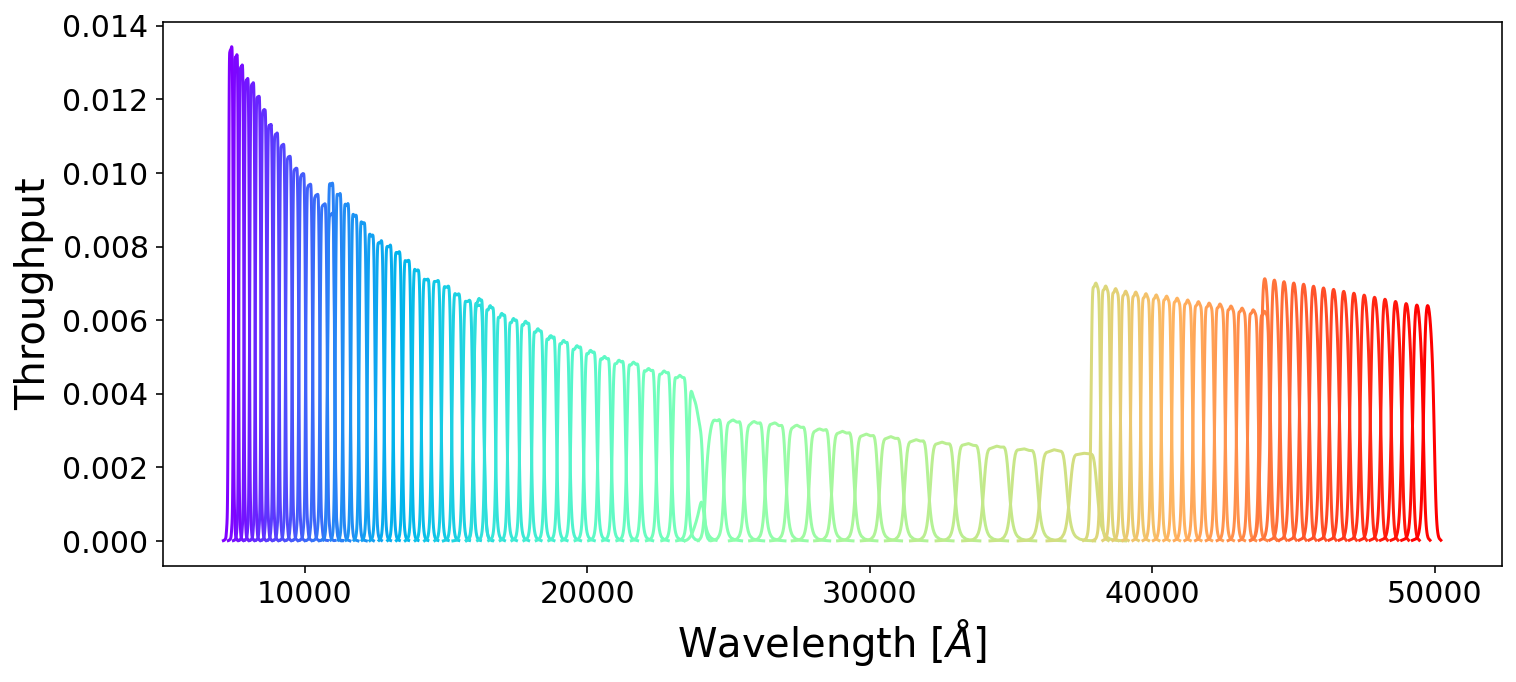

In [11]:
res = eazy.filters.FilterFile(WD/'FILTERS+spherex_reduced.res')

res_sphx = np.array(res.filters)[res.search('SPHEREx', verbose=False)]
Nchan_total = len(res_sphx)
colors = plt.cm.rainbow(np.linspace(0, 1, Nchan_total))
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
for i, filt in enumerate(res_sphx):
    ax.plot(filt.wave, filt.throughput, color=colors[i])

ax.set_xlabel(r'Wavelength [$\AA$]')
ax.set_ylabel('Throughput')

7130.09 11355.7
11355.7 16626.8
16626.8 24323.2
24323.2 39051.6
39051.6 44465.0
44465.0 50209.5
1994


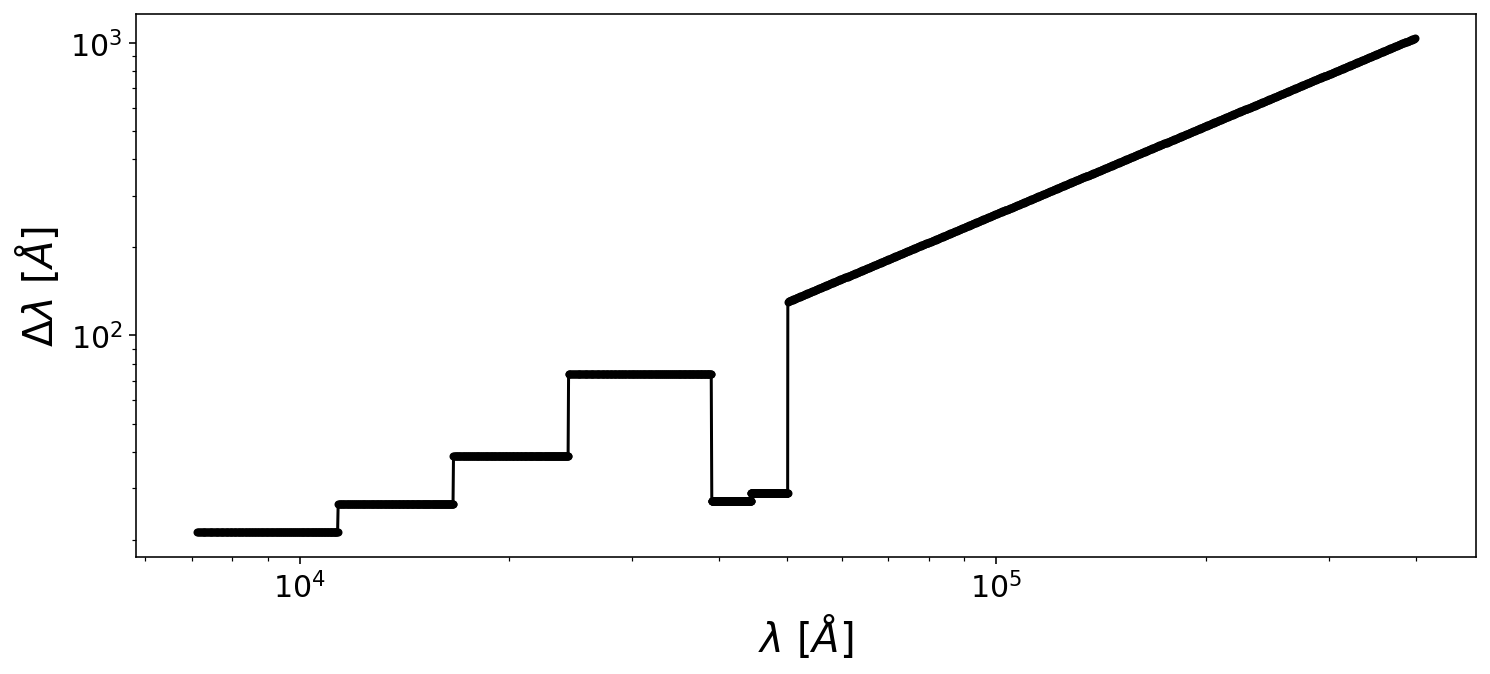

In [15]:
lamb_size = 1000
lamb_size_band = 200
zmax = 6.
lamb_list = []
lamb_max_before = None
for band in range(1,7):
    idx_band = res.search(f'SPHEREx_Band{band}', verbose=False)
    res_band = np.array(res.filters)[idx_band]
    
    lamb_min = np.min(res_band[0].wave) if band==1 else lamb_max_before
    lamb_max = np.max(res_band[-1].wave) #* (1 + zmax)
    
    # lamb_list.append(np.logspace(np.log10(lamb_min), np.log10(lamb_max), lamb_size_band))
    lamb_list.append(np.linspace(lamb_min, lamb_max, lamb_size_band))
    print(lamb_min, lamb_max)
    
    lamb_max_before = lamb_max
    
lamb_list.append(np.logspace(np.log10(lamb_max_before), np.log10(4e5), lamb_size - lamb_size_band)[1:])
lamb = np.unique(np.concatenate(lamb_list))

with open(WD/'lambda_for_spherex.def', 'w') as f:
    for l in lamb:
        f.write(f'{l:.6e}\n')

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(lamb[:-1], np.diff(lamb), '.-k', label='lambda')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda$ [$\AA$]')
ax.set_ylabel(r'$\Delta \lambda$ [$\AA$]')
print(len(lamb))

# Making EAZY `.template` file

In [51]:
lines = open("../BROWN_COSMOS.list").readlines()
with open(params['TEMPLATES_FILE'], 'w') as f:
    for i, line in enumerate(lines):
        if not line.startswith('#'):
            f.write(f'{i+1:3d} ../{line}')

# Making EAZY `.translate` file

In [8]:
ids_sphx = filters_spherex.search('SPHEREx', verbose=False)
nums_sphx = ids_sphx + 1

colnames = ['id']
for num in nums_sphx:
    colnames.append(f'F{num}')
    colnames.append(f'E{num}')

cat_synphot = Table.read(WD/'data/L3_COSMOS2020_Richard_2023DEC4_SPHEREx_fiducial102_for_photoz.txt',
                         format='ascii.no_header', names=colnames)
cat_synphot.write(WD/'data/spherex_synphot.dat', format='ascii.commented_header', overwrite=True)
del cat_synphot


with open(translate_filename, 'w') as f:
    for num in nums_sphx:
        f.write(f'F{num} F{num}\n')
        f.write(f'E{num} E{num}\n')


  419 SPHEREx_Band1_1 lambda_c= 6.9090e+03 AB-Vega= 0.360 w95=9992.6
  420 SPHEREx_Band1_2 lambda_c= 7.0989e+03 AB-Vega= 0.387 w95=9711.2
  421 SPHEREx_Band1_3 lambda_c= 7.4153e+03 AB-Vega= 0.424 w95=9346.2
  422 SPHEREx_Band1_4 lambda_c= 7.4454e+03 AB-Vega= 0.452 w95=9084.0
  423 SPHEREx_Band1_5 lambda_c= 7.5601e+03 AB-Vega= 0.484 w95=8761.8
  424 SPHEREx_Band1_6 lambda_c= 7.9043e+03 AB-Vega= 0.508 w95=8682.3
  425 SPHEREx_Band1_7 lambda_c= 7.9427e+03 AB-Vega= 0.553 w95=8377.5
  426 SPHEREx_Band1_8 lambda_c= 8.0093e+03 AB-Vega= 0.535 w95=8026.9
  427 SPHEREx_Band1_9 lambda_c= 8.6532e+03 AB-Vega= 0.550 w95=7737.0
  428 SPHEREx_Band1_10 lambda_c= 8.5533e+03 AB-Vega= 0.518 w95=7399.9
  429 SPHEREx_Band1_11 lambda_c= 9.2650e+03 AB-Vega= 0.561 w95=7028.0
  430 SPHEREx_Band1_12 lambda_c= 8.9319e+03 AB-Vega= 0.545 w95=6689.0
  431 SPHEREx_Band1_13 lambda_c= 9.6759e+03 AB-Vega= 0.572 w95=1186.8
  432 SPHEREx_Band1_14 lambda_c= 9.0150e+03 AB-Vega= 0.620 w95=374.5
  433 SPHEREx_Band1_15 lambda_

In [41]:
import gc
gc.collect()

124380

In [ ]:
ez = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_filename,
                        zeropoint_file=None, params=params, n_proc=30,
                        timeout=3600)

with open('tempfilt0001.pickle', 'wb') as wfile:
   pickle.dump(ez.tempfilt, wfile, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
ez = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_filename,
                        zeropoint_file=None, params=params, n_proc=20,
                        timeout=3600)

with open('tempfilt.pickle', 'wb') as wfile:
   pickle.dump(ez.tempfilt, wfile, protocol=pickle.HIGHEST_PROTOCOL)

~ 2 hours 18 minutes

In [11]:
ez.fit_catalog(ez.idx, n_proc=8)

ez.show_fit(id=0, savefig='fit.png')

  4%|▎         | 24/649 [52:13<22:40:01, 130.56s/it]Process ForkPoolWorker-27:
KeyboardInterrupt

Process ForkPoolWorker-24:
Process ForkPoolWorker-25:
Process ForkPoolWorker-21:
Process ForkPoolWorker-22:
Process ForkPoolWorker-23:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/data1/hbahk/envs/main/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/data1/hbahk/envs/main/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/data1/hbahk/envs/main/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/data1/hbahk/envs/main/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/data1/hbahk/envs/main/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kw

In [7]:
with open('tempfilt.pickle', 'rb') as rfile:
    tempfilt = pickle.load(rfile)
ez = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_filename,
                        zeropoint_file=None, params=params, tempfilt=tempfilt, )

Read default param file: /data1/hbahk/envs/main/lib/python3.9/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: data/spherex_synphot.dat
   >>> NOBJ = 166041
F419 E419 (419): SPHEREx_Band1_1
F420 E420 (420): SPHEREx_Band1_2
F421 E421 (421): SPHEREx_Band1_3
F422 E422 (422): SPHEREx_Band1_4
F423 E423 (423): SPHEREx_Band1_5
F424 E424 (424): SPHEREx_Band1_6
F425 E425 (425): SPHEREx_Band1_7
F426 E426 (426): SPHEREx_Band1_8
F427 E427 (427): SPHEREx_Band1_9
F428 E428 (428): SPHEREx_Band1_10
F429 E429 (429): SPHEREx_Band1_11
F430 E430 (430): SPHEREx_Band1_12
F431 E431 (431): SPHEREx_Band1_13
F432 E432 (432): SPHEREx_Band1_14
F433 E433 (433): SPHEREx_Band1_15
F434 E434 (434): SPHEREx_Band1_16
F435 E435 (435): SPHEREx_Band1_17
F436 E436 (436): SPHEREx_Band2_1
F437 E437 (437): SPHEREx_Band2_2
F438 E438 (438): SPHEREx_Band2_3
F439 E439 (439): SPHEREx_Band2_4
F440 E440 (440): SPHEREx_Band2_5
F441 E441 (441): SPHEREx_Band2_6
F442 E442 (442): SPHEREx_Band2_7
F443 E443 (443): SPHEREx_Band

Set sys_err = 0.01 (positive=True)


Read PRIOR_FILE:  ../prior_K_TAO.dat


649it [03:44,  2.88it/s]
100%|██████████| 649/649 [00:03<00:00, 183.89it/s] 


Compute best fits
fit_best: 0.0 s (n_proc=1,  NOBJ=10)
Fit 8.4 s (n_proc=8, NOBJ=10)


In [12]:
ez.fit_catalog(ez.idx[20000:30000], n_proc=16)

100%|██████████| 649/649 [1:13:30<00:00,  6.80s/it]


Compute best fits
fit_best: 44.1 s (n_proc=2,  NOBJ=29833)
Fit 4461.2 s (n_proc=16, NOBJ=10000)


In [13]:
zout, hdu = ez.standard_output(prior=True, beta_prior=False)
zout.write('output.fits', overwrite=True)

Get best fit coeffs & best redshifts


/data1/hbahk/envs/main/lib/python3.9/site-packages/eazy/photoz.py:6144: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  draws = np.random.multivariate_normal((coeffs_i*An)[ok_temp],
/data1/hbahk/envs/main/lib/python3.9/site-packages/eazy/photoz.py:6144: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  draws = np.random.multivariate_normal((coeffs_i*An)[ok_temp],


fit_best: 89.8 s (n_proc=2,  NOBJ=29833)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


  0%|          | 0/29833 [00:00<?, ?it/s]/data1/hbahk/envs/main/lib/python3.9/site-packages/eazy/photoz.py:6144: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  draws = np.random.multivariate_normal((coeffs_i*An)[ok_temp],
100%|██████████| 29833/29833 [22:43<00:00, 21.88it/s]



 Couldn't find template parameters file BROWN_COSMOS.template.fits for population synthesis 
 calculations.
            


/data1/hbahk/envs/main/lib/python3.9/site-packages/eazy/photoz.py:4111: RuntimeWarning: invalid value encountered in divide
  coeffs_norm = (coeffs_norm.T/coeffs_norm.sum(axis=1)).T
/data1/hbahk/envs/main/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/data1/hbahk/envs/main/lib/python3.9/site-packages/eazy/photoz.py:4146: RuntimeWarning: invalid value encountered in divide
  draws_norm = (draws_norm.T/draws_norm.sum(axis=2).T).T
100%|██████████| 29833/29833 [1:07:45<00:00,  7.34it/s]


Abs Mag filters [271, 272, 274]
Rest-frame filters:
~~~~~~~~~~~~~~~~~~~ 
   0 RestUV/Tophat_1700_200.dat lambda_c= 1.6989e+03 AB-Vega=1.916 w95=190.7
   1 RestUV/Tophat_2200_200.dat lambda_c= 2.1993e+03 AB-Vega=1.691 w95=191.1
   2 RestUV/Tophat_2800_200.dat lambda_c= 2.7996e+03 AB-Vega=1.465 w95=191.2


100%|██████████| 3/3 [12:11<00:00, 243.91s/it]


 ... rest-frame flux: 732.8 s (n_proc=3,  NOBJ=29930)


/data1/hbahk/envs/main/lib/python3.9/site-packages/astropy/cosmology/flrw/base.py:1343: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
/data1/hbahk/envs/main/lib/python3.9/site-packages/eazy/photoz.py:3960: RuntimeWarning: divide by zero encountered in log10
  obsm = self.param.params['PRIOR_ABZP'] - 2.5*np.log10(rf[:,i,:])
/data1/hbahk/envs/main/lib/python3.9/site-packages/eazy/photoz.py:3960: RuntimeWarning: invalid value encountered in log10
  obsm = self.param.params['PRIOR_ABZP'] - 2.5*np.log10(rf[:,i,:])


In [ ]:
with open('tempfilt.pickle', 'rb') as rfile:
    tempfilt = pickle.load(rfile)

for i in range(17):
    start_id = i * 10000
    end_id = (i+1) * 10000

    ez = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_filename,
                            zeropoint_file=None, params=params, tempfilt=tempfilt, )
    
    if end_id > len(ez.idx):
        end_id = len(ez.idx)
        
    ez.fit_catalog(ez.idx[start_id:end_id], n_proc=16)
    zout, hdu = ez.standard_output(prior=True, beta_prior=False)
    zout[start_id:end_id].write(dir_output/f'output{i:02d}.fits', overwrite=True)
    phdu = fits.PrimaryHDU(data=ez.lnp[start_id:end_id])
    gridhdu = fits.ImageHDU(data=ez.zgrid)
    hdul = fits.HDUList([phdu, gridhdu])
    hdul.writeto(dir_output/f'lnp{i:02d}.fits', overwrite=True)
    del ez, zout, hdu, phdu, gridhdu, hdul
    gc.collect()

In [32]:
from astropy.io import fits
hdul = fits.open('lnp5000.fits')
hdul.info()

Filename: lnp5000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (649, 166041)   float32   
  1                1 ImageHDU         6   (649,)   float32   
